## Sensitivity Test of Domain-averaged Precipitation
- Constrain precipitation by satellite-based cloud-top height distribution
- Find the precipitation efficiency $\chi$

### Python packages

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import colormaps as cmaps

### Functions

In [2]:
# Latent heat of vaporization of water as a function of temperature [K]
def Lv(T):
    return 2.501e6 + (Cpv - Cw) * (T - T0) # [J/kg]

# Wexler/Buck 1981 formula (with enhancement factor at standard pressure)
def es_wexler(T_C, P=1013.25):  # P in hPa
    return 1e2 * 6.1121 * (1.0007 + 3.46e-6 * P) * np.exp((17.502 * T_C) / (240.97 + T_C))

# Saturation vapor pressure calculations
def q_sat(T_C, p=101325):  # p in Pa (default = 1013.25 hPa)
    epsilon = Rd / Rv  # ratio of gas constants
    #es = es_clausius_clapeyron(T_C)
    #es = es_tetens(T_C)
    es = es_wexler(T_C)
    return (epsilon * es) / (p - (1 - epsilon) * es)

# Total water content calculation
def q_total(ae, dz, x, qs, qm, q_zcb, izcb):
    qtilde = (1 - x) * qm + x * qs

    qt = qtilde.copy()
    qt[0:izcb+1] = q_zcb  # set sub-cloud specific humidity
                          # Python is start inclusive, end exclusive, so must use izcb+1
                          # So qt[0:izcb+1] includes qt[izcb]
    for iz in range(izcb, len(qt)-1):
        if qt[iz] > qs[iz]:
            a1 = ae * dz
            Q1 = (qtilde[iz+1] + qtilde[iz]) / 2
            qt[iz+1] = ( (1-a1/2) * qt[iz] + a1*Q1 ) / (1 + a1/2)
        else:
            a2 = (1 - x) * ae * dz
            Q2 = (qm[iz+1] + qm[iz]) / 2
            qt[iz+1] = ( (1-a2/2) * qt[iz] + a2*Q2 ) / (1 + a2/2)
    return qt

def cloudflux_downward(ae, dz, x, ql, qm, qs, Ft, izcb, izct):
    Q = x * ae * ql / (qs - qm) * dz
    Fcld = Ft.copy()
    Fcld[:izct] = np.nan
    for iz in range(izct, izcb-1, -1):
        Fcld[iz] = (Ft[iz] - Ft[iz+1] + Fcld[iz+1] * (1 + Q[iz+1]/2)) / (1 - Q[iz]/2)
    return Fcld

### Data

In [3]:
# GOES-16 data
gdir = "/Users/huang/Data/SimonsCAT/ATOMIC/GOES-16/2020"
dsg  = xr.open_dataset(Path(gdir, "goes16_binned_low4km_20200115_20200219.nc"))

# Ronald Brown data
rdir = "/Users/huang/Data/SimonsCAT/ATOMIC/RonBrown"
dsr  = xr.open_dataset(Path(rdir, "RonBrown_radiosondes.nc"))
dss  = xr.open_dataset(Path(rdir, "RonBrown_10min_flux.nc"))

### Variables

In [4]:
# Variables from GOES-16 data
rfv_nrm = dsg['rfv_nrm'].values
rfv_acc = dsg['rfv_acc'].values
cth_bin = dsg['cth_bin'].values
# vf      = dsg['valid_fraction'].values

# Variables from Ronald Brown data
# Mean profiles over soundings
z    = dsr['alt'].values       # shape (alt,) [m]
tam  = dsr['ta'].mean(dim='sounding', skipna=True).values # mean air temperature [K]
# thm  = dsr['theta'].mean(dim='sounding', skipna=True).values
qm   = dsr['q'].mean(dim='sounding', skipna=True).values # mean specific humidity [kg/kg]
pm   = dsr['p'].mean(dim='sounding', skipna=True).values # mean air pressure [Pa]

# Mean fluxes over 10-min intervals
# lhf  = dss['hl_bulk'].values.squeeze()  # surface downward latent heat flux [W/m^2]
pr   = dss['prate'].values.squeeze()    # precipitation rate [mm/hr]
# ep   = dss['evap'].values.squeeze()    # evaporation rate [mm/hr]
rho  = dss['rhoair10'].values.squeeze()  # surface air density at 10-m [kg/m^3]
tair = dss['tair_ship'].values.squeeze()  # surface air temperature [degC]

In [5]:
# Constants
Cpv     = 1870   # Specific heat capacity of water vapor at constant pressure [J/kg/K] Bolton
Cw      = 4190   # Specific heat capacity of liquid water at constant pressure [J/kg/K] Bolton
Rv      = 461.5  # Gas constant for water vapor [J/kg/K]
Rd      = 287.04 # Gas constant for dry air [J/kg/K]
T0      = 273.15 # Reference temperature [K]

zi      = 3000   # Inversion height [m]
ztop    = 4000   # Top of trade cumulus cloud layer [m]
divg    = 1e-6   # Divergence of vertical velocity [s^-1]
# rho_sfc = 1.16   # Surface density [kg/m^3] obtained from surface data instead

Ecb     = 145    # Evaporation rate at cloud base [W/m^2]

In [6]:
# Variables derived from mean profiles
qs   = q_sat(tam - T0, pm)  # saturation specific humidity
dz   = (z[1] - z[0])        # vertical grid spacing in m
# dqdz = np.gradient(qm, dz)  # vertical gradient of specific humidity (central difference)
dqdz = np.diff(qm) / dz     #                                        (forward difference)

Lv_m = Lv(np.nanmean(tam[z <= ztop])) # latent heat of vaporization avg lower than ztop [2.47e+6 J/kg]
Lvsfc_m = Lv(np.nanmean(tair) + T0)  # latent heat of vaporization at surface [2.44e+6 J/kg]

rho_sfc = np.nanmean(rho)  # surface air density [kg/m^3]

# Latent heat of vaporization times density avg lower than ztop
rho_L = np.nanmean(pm[z <= ztop]) / (Rd * np.nanmean(tam[z <= ztop])) * Lv_m # [kg/m^3 J/kg]
# Latent heat of vaporization times surface density
rhosfc_L = rho_sfc * Lvsfc_m # [kg/m^3 J/kg]

In [7]:
# Calculations: large-scale advections (prescribed, i.e., the A term)
# Vertical velocity w(z) = -divg * z [m/s]
# Vertical moisture advection (subsidence drying: -w(z) * dq/dz)
w_dqdz = -( -divg * np.minimum(z[:-1], zi) ) * dqdz  # [1/s] # use z if dqdz is central difference

# Horizontal moisture advection (moisture convergence: ui * dq/dxi)
u_dqdx = -1.7e-8 * np.maximum(0, (ztop - z[:-1])/ztop)

ls_adv = w_dqdz + u_dqdx

### Use $\chi$ and $\alpha+\epsilon$ to infer precipitation at surface
- With pre-selected precipitation of 25.7 $Wm^{-2}$ from surface observational domain average.
- Cloud-base height: 700 m
- Precipitation efficiency ($\chi$) range: 0 to 1
- Total sink rate (auto-conversion $\alpha$ and entrainment $\epsilon$ coefficients) range: 0.5 to 5

$\chi=\alpha/(\alpha+\epsilon)$

In [8]:
# Since this preciptiation is observed at surface, we convert it to W/m2 using surface density (rhosfc_L)
print('Domain-averaged precipitation from Ronald Brown surface observations:', np.round(np.nanmean(pr), 2), 
        'mm/hr =', np.round(np.nanmean(pr)*rhosfc_L/3600, 2), 'W/m2')

Domain-averaged precipitation from Ronald Brown surface observations: 0.03 mm/hr = 25.4 W/m2


In [9]:
# Calculations
Fcb = Ecb / rho_L - np.nanmean(pr) / 3600 # [kg/m^2/s]
zcb = 700
x_range = np.arange(0, 1.01, 0.01)
ae_range = 1e-3 * np.arange(0.5, 5.01, 0.01)

pr_pred = np.zeros((len(x_range), len(ae_range))) # predicted precipitation flux at cloud-base [kg/m^2/s]
cth_pred = np.zeros((len(x_range), len(ae_range))) # predicted cloud-top height [m]
ac = np.zeros((len(x_range), len(ae_range)))
ec = np.zeros((len(x_range), len(ae_range)))
for ix in range(len(x_range)):
    for iae in range(len(ae_range)):
        # print(f"Case with α+ϵ={ae_range[iae]*1e+3} 1/km and x={x_range[ix]:.2f}")
        ae = ae_range[iae]
        x = x_range[ix]

        izcb = np.where(z >= zcb)[0][0]  # find index where height is greater than or equal to zcb
        q_zcb = qs[izcb]  # specific humidity at cloud base height

        # Integrate total flux balancing subsidence drying and horizontal advection from cloud base
        Ft = qm.copy()
        Ft[1:izcb] = np.nan
        ls_adv_cumsum = np.concatenate( ([0], np.cumsum(ls_adv[izcb:] * dz)) )
        Ft[izcb:] = Fcb + ls_adv_cumsum

        # Calculate total water content
        qt = q_total(ae, dz, x, qs, qm, q_zcb, izcb)
        ql = np.maximum(qt - qs, 0.0)           # cloud liquid water content

        # Find the cloud-top height where ql goes to zero above the cloud base
        izct = np.where(ql[izcb+1:] == 0)[0][0] + izcb

        # Calculations: cloud fluxes for control case
        Fcld = cloudflux_downward(ae, dz, x, ql, qm, qs, Ft, izcb, izct)
        Fpr = Fcld - Ft # Precipitation flux must be zero above cloud top

        pr_pred[ix, iae] = Fpr[izcb]
        cth_pred[ix, iae] = z[izct]
        ac[ix, iae] = x * ae       # autoconversion coefficient
        ec[ix, iae] = (1 - x) * ae # entrainment coefficient

In [10]:
# Only keep cth_pred > 4000
prwm2 = rho_L * pr_pred # convert to W/m^2 (since this preciptation flux is at cloud-base, we use rho_L instead of rhosfc_L)
print([np.nanmin(prwm2), np.nanmax(prwm2)])

prwm2keep = np.where((cth_pred <= 4000), prwm2, np.nan)
print([np.nanmin(prwm2keep), np.nanmax(prwm2keep)])

wm2_levels = np.arange(0, 105, 5) # for contour levels

# Only make cth_pred > 4000 NaN
cthkeep = np.where((cth_pred <= 4000), cth_pred, np.nan)

print([np.nanmin(cthkeep), np.nanmax(cthkeep)])
cth_levels = np.arange(800, 4000+100, 200)/1000 # for contour levels

[0.0, 1.2623078274699743e+19]
[0.0, 198.07728584922842]
[700.0, 3400.0]


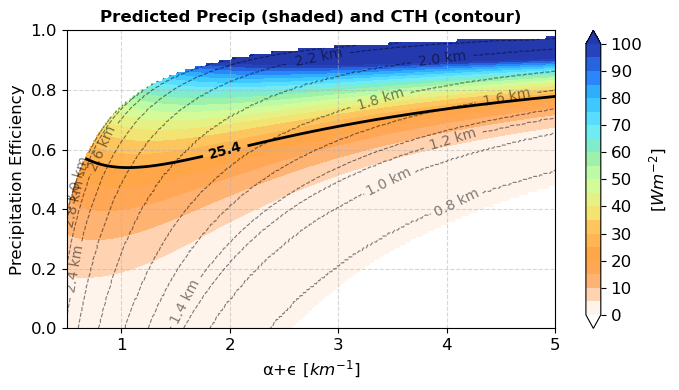

In [11]:
# Plot predicted precipitation and cloud-top height
plt.figure(figsize=(7, 4))

plt.contourf(ae_range * 1e+3, x_range, prwm2keep, levels=wm2_levels, 
             cmap=cmaps.cmp_haxby_r, extend='both')
cb = plt.colorbar()
cb.set_label(r'[$Wm^{-2}$]', fontsize=12)
cb.set_ticks(np.arange(0, 105, 10))
cb.set_ticklabels(np.arange(0, 105, 10), fontsize=12)

cs_pr = plt.contour(ae_range * 1e+3, x_range, prwm2keep, 
            levels=[rhosfc_L*np.nanmean(pr)/3600], colors='k',
            linestyles='-', linewidths=2)
lb = plt.clabel(cs_pr, fmt=lambda v: f"{v:.1f}", colors='k', fontsize=10)
for ilb in lb:
    ilb.set_fontweight('bold')

cs_cth = plt.contour(ae_range * 1e+3, x_range, cthkeep/1000, levels=cth_levels, colors='k',
            linestyles='--', linewidths=0.8, alpha=0.5)
plt.clabel(cs_cth, fmt=lambda v: f"{v:.1f} km", colors='k', fontsize=10)

plt.xlabel(r'α+ϵ [$km^{-1}$]', fontsize=12)
plt.ylabel('Precipitation Efficiency', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Predicted Precip (shaded) and CTH (contour)', fontsize=12, fontweight='bold')
plt.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

### Project cloud fraction (inferred from the GOES-16 cloud-top height distribution) onto this diagram

In [12]:
# Averaging 1192 profiles of weighted cloud-top height distribution
rfv_nrm_avg = rfv_nrm.mean(axis=0)
rfv_acc_avg = rfv_acc.mean(axis=0) # cloud fraction

In [20]:
# Projecting cloud fraction onto the x-ae diagram
idtop = np.zeros(len(x_range))
matched_nrm = np.zeros((len(x_range), len(ae_range)))
matched_acc = np.zeros((len(x_range), len(ae_range)))
pr_weighted = np.zeros((len(x_range), len(ae_range)))
pr_weighted_sum = np.zeros(len(x_range))
for ix in range(len(x_range)):
    idtop0 = np.where(cth_pred[ix,:]<4000)[0]
    if np.where(cth_pred[ix,:]<4000)[0].size == 0:
        idtop[ix] = np.nan
    else:
        idtop[ix] = idtop0[0]
        matched_nrm[ix, int(idtop[ix]):] = np.interp(cth_pred[ix, int(idtop[ix]):], cth_bin*1000, rfv_nrm_avg)
        matched_acc[ix, int(idtop[ix]):] = np.interp(cth_pred[ix, int(idtop[ix]):], cth_bin*1000, rfv_acc_avg)
        pr_weighted[ix, int(idtop[ix]):] = (rho_L * pr_pred[ix, int(idtop[ix]):] * matched_nrm[ix, int(idtop[ix]):])
        pr_weighted_sum[ix] = pr_weighted[ix, int(idtop[ix]):].sum()/matched_acc[ix, -1]
        # print('X = ', x_range[ix], '; Precip = ', np.round(pr_weighted_avg[ix],2), 'Wm^-2')

acc_levels = np.arange(0, 10.1, 1)

# Find the precipitation efficiency
pr_avg = np.nanmean(pr) * rhosfc_L / 3600 # Wm^-2
imax = np.argmax(pr_weighted_sum)
x_final = np.interp(pr_avg, pr_weighted_sum[:imax+1], x_range[:imax+1])

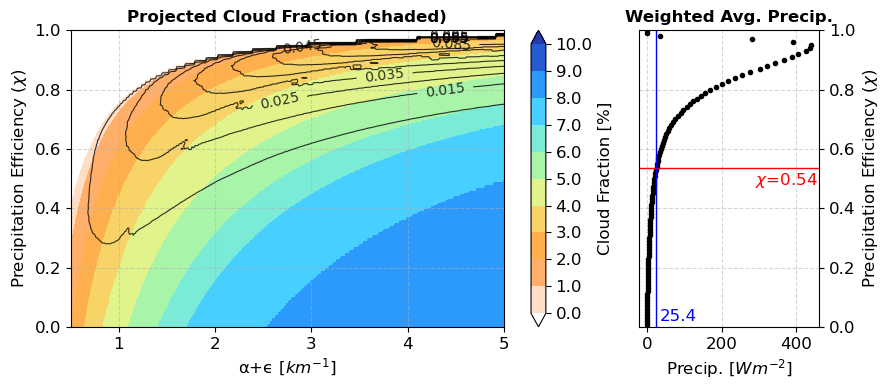

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [3, 1]})

# Cloud fraction
cs = ax1.contourf(ae_range * 1e+3, x_range, matched_acc*100, levels=acc_levels, 
            cmap=cmaps.cmp_haxby_r, extend='both')

cb = fig.colorbar(cs, ax=ax1)
cb.set_label(r'Cloud Fraction [%]', fontsize=12)
cb.set_ticks(np.arange(0, 10.1, 1))
cb.set_ticklabels(np.arange(0, 10.1, 1), fontsize=12)

cs_pr = ax1.contour(ae_range * 1e+3, x_range, pr_weighted, levels=np.arange(0.005, 0.105, 0.01), colors='k',
            linestyles='-', linewidths=0.8, alpha=0.8)
ax1.clabel(cs_pr, fmt=lambda v: f"{v:.3f}", colors='k', fontsize=10)

# cs_cth = ax1.contour(ae_range * 1e+3, x_range, cthkeep/1000, levels=cth_levels, colors='k',
#             linestyles='--', linewidths=0.8, alpha=0.5)
# ax1.clabel(cs_cth, fmt=lambda v: f"{v:.1f} km", colors='k', fontsize=10)

ax1.set_xlabel(r'α+ϵ [$km^{-1}$]', fontsize=12)
ax1.set_ylabel(f'Precipitation Efficiency ($\chi$)', fontsize=12)
ax1.set_title(rf'Projected Cloud Fraction (shaded)', fontsize=12, fontweight='bold')

ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)
ax1.grid(linestyle='--', alpha=0.5)

# Weighted precipitation
ax2.plot(pr_weighted_sum, x_range, '.', color='k')
ax2.axhline(x_final, color='r', linewidth=1)
ax2.axvline(pr_avg, color='b', linewidth=1)

ax2.set_ylim(0, 1)

ax2.set_xlabel(r'Precip. [$Wm^{-2}$]', fontsize=12)
ax2.set_ylabel(f'Precipitation Efficiency ($\chi$)', fontsize=12)
ax2.set_title(rf'Weighted Avg. Precip.', fontsize=12, fontweight='bold')
ax2.text(290, 0.48, f'$\chi$={np.round(x_final, 2)}', fontsize=12, color='r')
ax2.text(35, 0.02, f'{np.round(pr_avg, 2)}', fontsize=12, color='b')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.tick_params(axis='x', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.grid(linestyle='--', alpha=0.5)

plt.tight_layout()